In [7]:
import haiku as hk
import jax
import jraph


def network_definition(
    graph: jraph.GraphsTuple, num_message_passing_steps: int = 5
) -> jraph.ArrayTree:
    """Defines a graph neural network.
    Args:
      graph: Graphstuple the network processes.
      num_message_passing_steps: number of message passing steps.
    Returns:
      Decoded nodes.
    number_message_passing_steps = number of layers
    """
    network_type = "GCN"
    embedding = jraph.GraphMapFeatures(
        embed_edge_fn=jax.vmap(hk.Linear(output_size=16)),
        embed_node_fn=jax.vmap(hk.Linear(output_size=16)),
    )

    graph = embedding(graph)

    def mlp(dims):
        net = []
        for d in dims:
            net.extend([hk.Linear(d), jax.nn.relu])
        return hk.Sequential(net)

    @jax.vmap
    @jraph.concatenated_args
    def update_fn(features):
        net = mlp([20, 20, 20])
        # net = mlp([40, 40, 40])
        return net(features)

    if network_type == "GCN":
        for _ in range(num_message_passing_steps):
            gn = jraph.GraphConvolution(
                update_node_fn=update_fn,
            )
            # NOTE: implementation does not add an activation after aggregation; if we
            # stack layers, we might want to add an activation between each layer
            # update_node_fn: function used to update the nodes. In the paper a single
            # layer MLP is used.
            # aggregate_nodes_fn: function used to aggregates the sender nodes.
            # add_self_edges: whether to add self edges to nodes in the graph as in the
            # paper definition of GCN. Defaults to False.
            # symmetric_normalization: whether to use symmetric normalization. Defaults
            # to True. Note that to replicate the fomula of the linked paper, the
            # adjacency matrix must be symmetric. If the adjacency matrix is not
            # symmetric the data is prenormalised by the sender degree matrix and post
            # normalised by the receiver degree matrix.
            graph = gn(graph)
            # graph = graph._replace(nodes=jax.nn.relu(graph.nodes))
            # gn = jraph.GraphConvolution(
            #    update_node_fn=update_fn,
            #)
            # graph = gn(graph)
    


    if network_type == "interaction":
        for _ in range(num_message_passing_steps):
            gn = jraph.InteractionNetwork(
                update_edge_fn=update_fn,
                update_node_fn=update_fn,
                include_sent_messages_in_node_update=True,
            )
            # update_edge_fn: a function mapping a single edge update inputs to a single edge feature.
            # update_node_fn: a function mapping a single node update input to a single node feature.
            # aggregate_edges_for_nodes_fn: function used to aggregate messages to each node.
            # include_sent_messages_in_node_update: pass edge features for which a node is a sender to the node update function.
            graph = gn(graph)
    return hk.Linear(2)(graph.nodes)


def get_model_probabilities(network, params, problem):
    """
    Helper method that returns, for each, problem variable, the Bernoulli parameter of the model for this variable.
    That is, the ith value of the returned array is the probability with which the model will assign 1 to the
    ith variable.

    The reasoning for choosing the first, rather than the zeroth, column of the model output below is as follows:

    - When evaluating the loss function, candidates are one-hot encoded, which means that when a satisfying assignment
    for a problem sets variable i to 1, then this will increase the likelihood that the model will set this variable to
    1, meaning, all else being equal, a larger Bernoulli weight in element [i,1] of the model output. As a result the
    right column of the softmax of the model output equals the models likelihood for setting variables to 1, which is
    what we seek.
    """
    n, _, _ = problem.params
    decoded_nodes = network.apply(params, problem.graph)
    return jax.nn.softmax(decoded_nodes)[:n, 1]


In [10]:
import collections

import haiku as hk
import jax
import jax.numpy as jnp
import numpy as np
import optax
import time
from torch.utils import data
import matplotlib.pyplot as plt
import pandas as pd
import moser_rust
from data_utils import SATTrainingDataset, JraphDataLoader
from random_walk import moser_walk
import mlflow
from pathlib import Path
import tempfile
import joblib

NUM_EPOCHS = 10  # 10
f = 0.1
batch_size = 2
path = "../../Data/blocksworld_single"
N_STEPS_MOSER = 1000
N_RUNS_MOSER = 2
SEED = 0

# MODEL_REGISTRY = Path("experiment_tracking/experiments_storing")
# EXPERIMENT_NAME = "mlflow-demo2"


#  AUXILIARY METHODS


def one_hot(x, k, dtype=jnp.float32):
    """Create a one-hot encoding of x of size k."""
    return jnp.array(x[:, None] == jnp.arange(k), dtype)


vmap_one_hot = jax.vmap(one_hot, in_axes=(0, None), out_axes=0)


def compute_log_probs(decoded_nodes, mask, candidate):
    a = jax.nn.log_softmax(decoded_nodes) * mask[:, None]
    return candidate * a


vmap_compute_log_probs = jax.vmap(
    compute_log_probs, in_axes=(None, None, 1), out_axes=1
)


def evaluate_on_moser(
    network,
    params,
    problem,
    n_steps,
    keep_trajectory=False,
):
    model_probabilities = get_model_probabilities(network, params, problem)
    _, energy, _ = moser_walk(
        model_probabilities, problem, n_steps, seed=0, keep_trajectory=keep_trajectory
    )
    _, m, _ = problem.params
    return np.min(energy) / m


def plot_accuracy_fig(*eval_results):
    ROLLING_WINDOW_SIZE = 1 #10
    for eval_result in eval_results:
        results = np.array(eval_result.results)
        if eval_result.normalize:
            results /= np.max(results)
        plt.plot(
            # np.arange(0, NUM_EPOCHS - ROLLING_WINDOW_SIZE, 1),
            pd.Series(results).rolling(ROLLING_WINDOW_SIZE).mean(),
            "o--",
            label=eval_result.name,
            alpha=0.4,
        )
    plt.xlabel("epoch")
    plt.ylabel("accuracy of model / loss")
    plt.grid()
    plt.legend()
    plt.tight_layout()
    plt.show()


EvalResults = collections.namedtuple("EvalResult", ("name", "results", "normalize"))


def train(
    batch_size,
    f,
    NUM_EPOCHS,
    N_STEPS_MOSER,
    N_RUNS_MOSER,
    path,
    img_path=False,
    model_path=False,
    experiment_tracking=False,
):
    sat_data = SATTrainingDataset(path)

    train_data, test_data = data.random_split(sat_data, [0.8, 0.2])
    train_eval_data, _ = data.random_split(train_data, [0.2, 0.8])

    train_loader = JraphDataLoader(train_data, batch_size=batch_size, shuffle=True)
    #test_loader = JraphDataLoader(test_data, batch_size=batch_size)
    #train_eval_loader = JraphDataLoader(train_eval_data, batch_size=batch_size)

    network = hk.without_apply_rng(hk.transform(network_definition))
    params = network.init(jax.random.PRNGKey(42), sat_data[0][0].graph)

    opt_init, opt_update = optax.adam(1e-3)
    opt_state = opt_init(params)

    @jax.jit
    def update(params, opt_state, batch, f):

        g = jax.grad(prediction_loss)(params, batch, f)

        updates, opt_state = opt_update(g, opt_state)
        return optax.apply_updates(params, updates), opt_state

    def prediction_loss(params, batch, f: float):
        (mask, graph), (candidates, energies) = batch
        decoded_nodes = network.apply(params, graph)  # (B*N, 2)
        candidates = vmap_one_hot(candidates, 2)  # (B*N, K, 2))
        log_prob = vmap_compute_log_probs(
            decoded_nodes, mask, candidates
        )  # (B*N, K, 2)
        weights = jax.nn.softmax(-f * energies)  # (B*N, K)
        loss = -jnp.sum(weights * jnp.sum(log_prob, axis=-1))  # ()
        # jax.debug.print("🤯 {x} 🤯", x=loss)
        return loss

    print("Entering training loop")

    def evaluate(loader):
        return np.mean([prediction_loss(params, b, f) for b in loader])

    def evaluate_moser_jax(data_subset):
        return np.mean(
            [
                evaluate_on_moser(
                    network, params, sat_data.get_unpadded_problem(i), N_STEPS_MOSER
                )
                for i in data_subset.indices
            ]
        )

    def evaluate_moser_rust(data_subset):

        av_energies = []

        for idx in data_subset.indices:
            problem_path = sat_data.instances[idx].name + ".cnf"
            problem = sat_data.get_unpadded_problem(idx)
            model_probabilities = get_model_probabilities(network, params, problem)
            _, _, final_energies = moser_rust.run_moser_python(
                problem_path,
                model_probabilities.ravel(),
                N_STEPS_MOSER,
                N_RUNS_MOSER,
                SEED,
            )
            _, m, _ = problem.params
            av_energies.append(np.mean(final_energies) / m)

        return np.mean(av_energies)

    #test_eval = EvalResults("Test loss", [], True)
    train_eval = EvalResults("Train loss", [], True)
    #test_moser_eval = EvalResults("Moser loss (test)", [], True)
    train_moser_eval = EvalResults("Moser loss (train)", [], True)
    eval_objects = [train_eval, train_moser_eval]

    for epoch in range(NUM_EPOCHS):
        start_time = time.time()
        for counter, batch in enumerate(train_loader):
            # print("batch_number", counter)
            params, opt_state = update(params, opt_state, batch, f)

        epoch_time = time.time() - start_time

        # print("Epoch {} in {:0.2f} sec".format(epoch, epoch_time))

        #test_eval.results.append(evaluate(test_loader))
        train_eval.results.append(evaluate(train_loader))
        #test_moser_eval.results.append(evaluate_moser_rust(test_data))
        train_moser_eval.results.append(evaluate_moser_rust(train_data))
        loss_str = "Epoch {} in {:0.2f} sec".format(epoch, epoch_time) + ";  "
        for eval_result in eval_objects:
            loss_str = (
                loss_str
                + f"{eval_result.name}: {np.round(eval_result.results[-1],4)}"
                + "; "
            )
            if experiment_tracking == True:
                mlflow.log_metric(eval_result.name, eval_result.results[-1], step=epoch)
        print(loss_str)

    if img_path:
        plot_accuracy_fig(*eval_objects)
        if img_path == "show":
            plt.show()
        else:
            plt.savefig(img_path + "accuracy.jpg", dpi=300, format="jpg")

    if model_path:
        model_params = [params, batch_size, f, NUM_EPOCHS]
        np.save(model_path, [model_params, *eval_objects])

    return {
        "params": params,
    }


# def save_dict(d, filepath):
#    """Save dict to a json file."""
#    with open(filepath, "w") as fp:
#        json.dump(d, indent=2, sort_keys=False, fp=fp)




Entering training loop
Loading problem with 1087 variables and 13772 clauses
Epoch 0 in 3.88 sec;  Train loss: 752.6367797851562; Moser loss (train): 0.0148; 
Round 1 ending with 296 violated clauses
Round 2 ending with 211 violated clauses
Loading problem with 1087 variables and 13772 clauses
Epoch 1 in 0.34 sec;  Train loss: 751.8234252929688; Moser loss (train): 0.015; 
Round 1 ending with 266 violated clauses
Round 2 ending with 232 violated clauses
Loading problem with 1087 variables and 13772 clauses
Epoch 2 in 0.34 sec;  Train loss: 751.010986328125; Moser loss (train): 0.0173; 
Round 1 ending with 266 violated clauses
Round 2 ending with 258 violated clauses
Loading problem with 1087 variables and 13772 clauses
Epoch 3 in 0.35 sec;  Train loss: 750.1998901367188; Moser loss (train): 0.0187; 
Round 1 ending with 344 violated clauses
Round 2 ending with 258 violated clauses
Loading problem with 1087 variables and 13772 clauses
Epoch 4 in 0.46 sec;  Train loss: 749.3897705078125; 

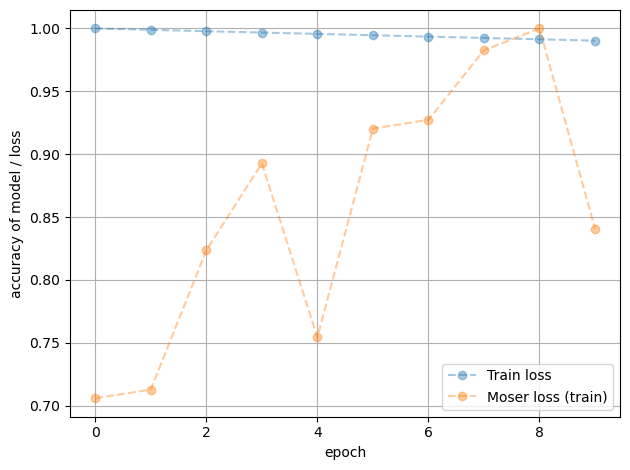

In [11]:
params = train(
                batch_size,
                f,
                NUM_EPOCHS,
                N_STEPS_MOSER,
                N_RUNS_MOSER,
                path,
                img_path="show",
                model_path=False,
                experiment_tracking=False,
            )